In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Lasso, Ridge


## 1) Load and explore the dataset, visualizing the results of the exploration. Analyze the quality of the dataset and handle eventual quality issues.


In [4]:
df = pd.read_csv('weight_change_dataset.csv')
display(df.head())

,Participant ID,Age,Gender,BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Smoking,Physical Activity Level,Sleep Quality,Stress Level,Work Sector,Final Weight (lbs)
0,0,56,M,3102.3,3916.0,NaN,14.57,1,-,Sedentary,Excellent,6,Public,228.6
1,1,46,M,2275.5,3823.0,1547.5,NaN,6,-,Very Active,Excellent,6,Public,167.8
2,2,32,M,2119.4,2785.4,666.0,NaN,7,Yes,Sedentary,Good,3,Self-Employed,144.2
3,3,25,M,2181.3,2587.3,406.0,3.37,8,-,Sedentary,Fair,2,Private,146.3
4,4,38,M,2463.8,3312.8,849.0,3.90,10,-,Lightly Active,Good,1,Unemployed,157.5


In [5]:
# Drop the 'Participant ID' column from the dataframe
df = df.drop(columns=['Participant ID'])

In [6]:
df.shape

(600, 13)

In [7]:
df.describe()

,Age,BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Duration (weeks),Stress Level,Final Weight (lbs)
count,600.000000,600.000000,544.000000,540.000000,544.000000,600.000000,600.000000,600.000000
mean,40.633333,2507.488800,3489.047224,981.939611,-2.750533,6.665000,4.716667,168.341300
std,26.724256,245.662118,351.436429,250.527087,6.934349,2.315537,1.677621,20.273139
min,-17.000000,1566.500000,2030.900000,82.500000,-42.990000,1.000000,1.000000,98.200000
25%,32.750000,2343.990000,3279.757500,817.367500,-6.425000,5.000000,4.000000,156.580000
50%,38.000000,2515.620000,3530.750000,979.700000,-2.305000,7.000000,5.000000,168.950000
75%,43.000000,2674.585000,3742.855000,1142.392500,1.475000,8.000000,6.000000,180.947500
max,207.000000,3390.800000,4000.000000,1922.500000,18.140000,12.000000,9.000000,232.500000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            600 non-null    int64  
 1   Gender                         600 non-null    object 
 2   BMR (Calories)                 600 non-null    float64
 3   Daily Calories Consumed        544 non-null    float64
 4   Daily Caloric Surplus/Deficit  540 non-null    float64
 5   Weight Change (lbs)            544 non-null    float64
 6   Duration (weeks)               600 non-null    int64  
 7   Smoking                        600 non-null    object 
 8   Physical Activity Level        600 non-null    object 
 9   Sleep Quality                  600 non-null    object 
 10  Stress Level                   600 non-null    int64  
 11  Work Sector                    540 non-null    object 
 12  Final Weight (lbs)             600 non-null    flo

The dataset has 14 features and 600 samples. There are some missing values.

____

Separating Continuous and Categorical features to analyse them separately

In [9]:
# List of continuous features
continuous_features = ['Age', 'BMR (Calories)', 'Daily Calories Consumed', 
                       'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 'Duration (weeks)', 'Stress Level', 'Final Weight (lbs)']

# List of categorical features
categorical_features = ['Gender', 'Smoking', 'Physical Activity Level', 'Sleep Quality', 'Work Sector']

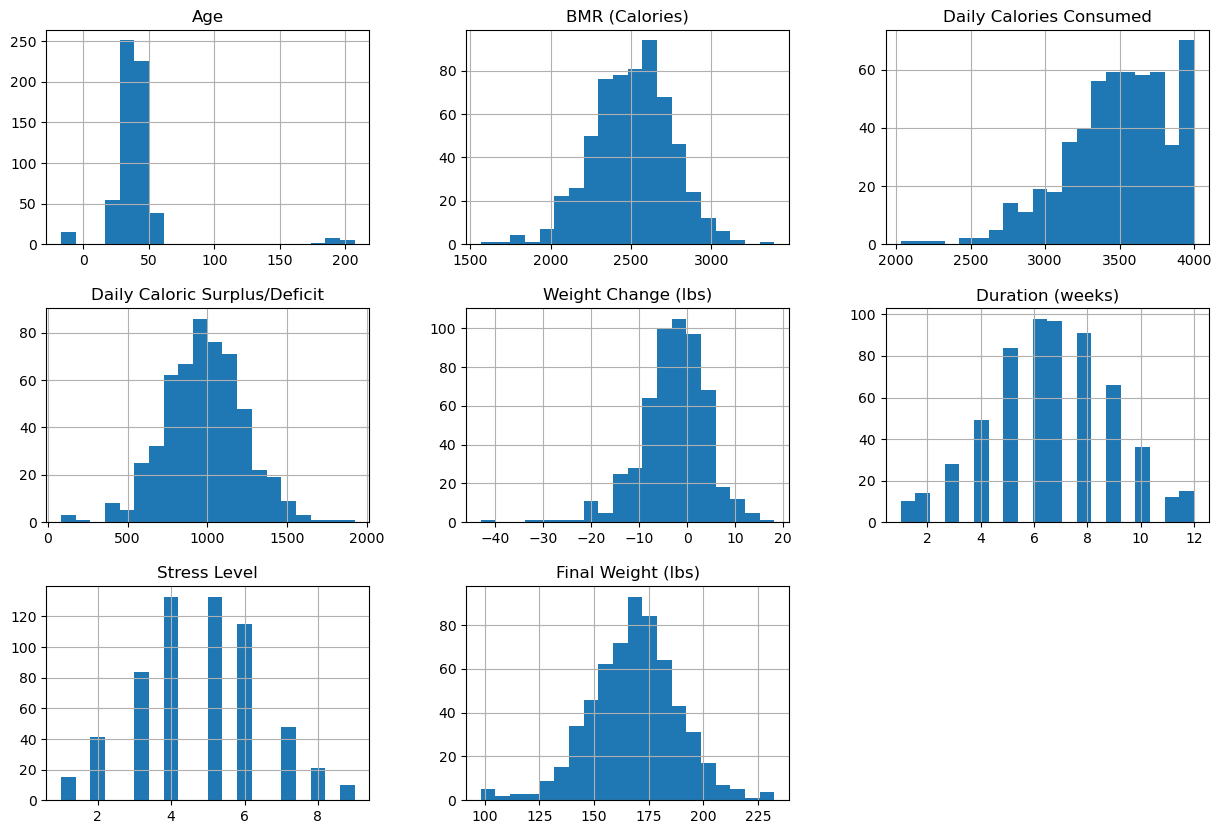

In [10]:
df[continuous_features].hist(bins=20, figsize=(15, 10))
plt.show()

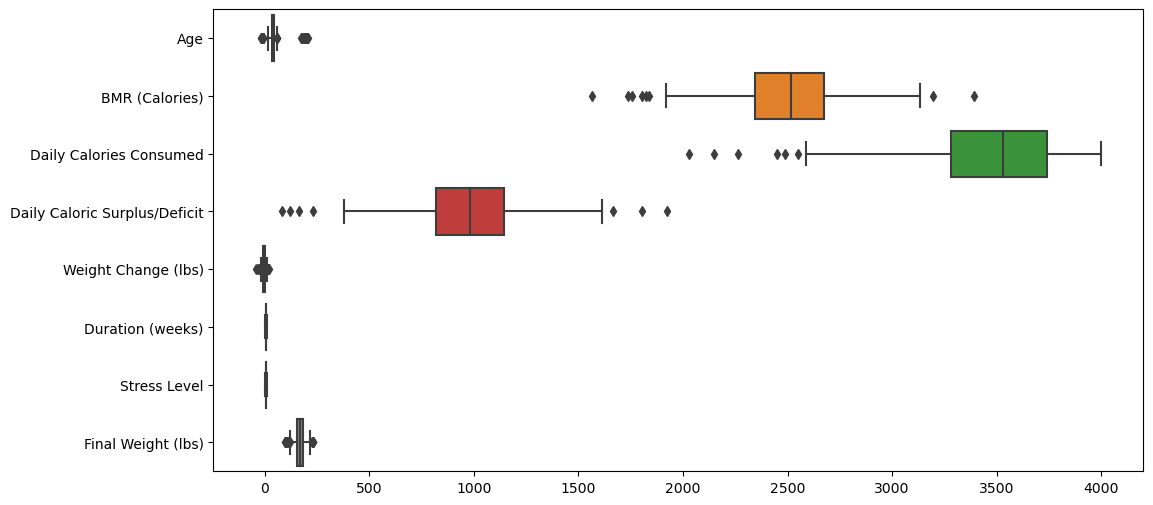

In [11]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[continuous_features], orient="h")
plt.show()

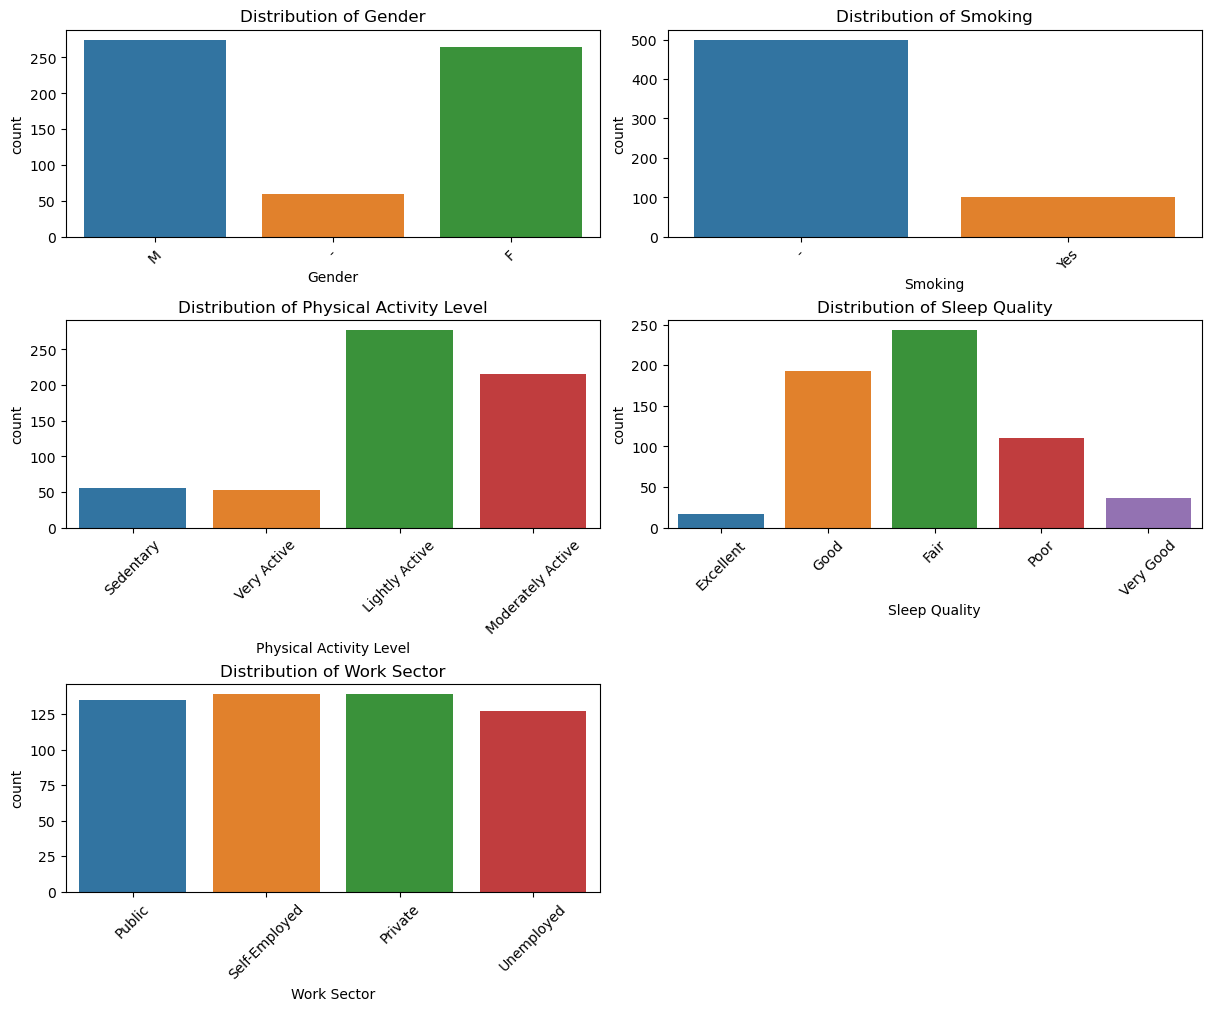

In [12]:
# Set up the figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10), constrained_layout=True)  # 3 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each feature and create a countplot in a subplot
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Hide the empty subplot (last subplot on the 3rd row)
axes[-1].set_visible(False)

plt.show()

___

Checking for Duplicates and removing Noise

In [13]:
print("Number of duplicate rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [14]:
# Remove rows with ages above 100
df = df[df['Age'] <= 100]

In [15]:
df = df.reset_index(drop=True)  # Reset index for the original DataFrame

Imputation of NaN values

There are some values in the Gender column that are neither M or F, they are -, which will be treated as NaN and then imputed with KNN.

In [16]:
df['Gender'].replace('-', np.nan, inplace=True)

# Temporarily convert Gender to numeric (Male: 0, Female: 1) for KNN imputation
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})

# Select relevant features for KNN imputation
features_for_knn = ['Age', 'BMR (Calories)', 'Daily Calories Consumed', 
                    'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 
                    'Duration (weeks)', 'Stress Level', 'Gender']

# Filter only relevant columns for imputation
df_knn = df[features_for_knn]

# Apply KNN Imputer to handle NaN in Gender
knn_imputer = KNNImputer(n_neighbors=5)
df_imputed_values = knn_imputer.fit_transform(df_knn)

# Create a DataFrame with the imputed values and the original column names
df_imputed = pd.DataFrame(df_imputed_values, columns=df_knn.columns)

# Round the imputed Gender values and map them back to categorical labels
df_imputed['Gender'] = df_imputed['Gender'].round().map({0: 'M', 1: 'F'})

In [17]:
df['Gender'] = df_imputed['Gender']

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            585 non-null    int64  
 1   Gender                         585 non-null    object 
 2   BMR (Calories)                 585 non-null    float64
 3   Daily Calories Consumed        530 non-null    float64
 4   Daily Caloric Surplus/Deficit  528 non-null    float64
 5   Weight Change (lbs)            533 non-null    float64
 6   Duration (weeks)               585 non-null    int64  
 7   Smoking                        585 non-null    object 
 8   Physical Activity Level        585 non-null    object 
 9   Sleep Quality                  585 non-null    object 
 10  Stress Level                   585 non-null    int64  
 11  Work Sector                    525 non-null    object 
 12  Final Weight (lbs)             585 non-null    flo

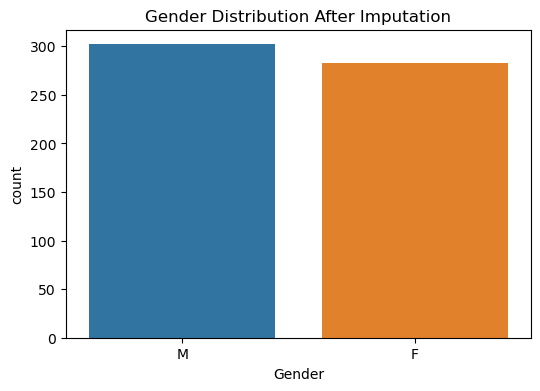

In [18]:
# Plot the Gender distribution after imputation
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender', order=df['Gender'].value_counts().index)
plt.title("Gender Distribution After Imputation")
plt.show()

Dropping the rows where both Daily calories and Daily caloric surplus/deficit is NaN since they are strictly correlated

In [19]:
df = df.dropna(subset=['Daily Calories Consumed', 'Daily Caloric Surplus/Deficit'], how='all')

df = df.reset_index(drop=True) 

Calculating the NaN values in the column 'Daily Caloric Suprlus/Deficit' knowing that it is calculated with 'Daily Calories Consumed' - 'BMR'

In [20]:
# Find rows where Daily Caloric Surplus/Deficit is NaN
nan_rows = df[df['Daily Caloric Surplus/Deficit'].isna()]

# Calculate the difference for those rows
nan_rows['Calculated Surplus/Deficit'] = nan_rows['Daily Calories Consumed'] - nan_rows['BMR (Calories)']

print("\nCalculated Surplus/Deficit for rows with NaN:\n", nan_rows[['Daily Calories Consumed', 'BMR (Calories)', 'Calculated Surplus/Deficit']])

# Now assign the calculated difference to the Daily Caloric Surplus/Deficit for these rows
df.loc[nan_rows.index, 'Daily Caloric Surplus/Deficit'] = nan_rows['Calculated Surplus/Deficit']


Calculated Surplus/Deficit for rows with NaN:
      Daily Calories Consumed  BMR (Calories)  Calculated Surplus/Deficit
0                    3916.00         3102.30                      813.70
8                    3890.20         2406.90                     1483.30
12                   2845.00         2483.70                      361.30
19                   3086.20         2003.80                     1082.40
28                   4000.00         2627.20                     1372.80
30                   4000.00         2581.90                     1418.10
34                   3521.70         2146.60                     1375.10
50                   3378.10         2517.70                      860.40
55                   3346.37         2394.83                      951.54
75                   2854.83         2210.30                      644.53
78                   2984.93         2181.33                      803.60
82                   2942.07         2373.63                      568.44
89 

/var/folders/0l/91zty_zs7bj5b_1bwsr3q2y40000gn/T/ipykernel_5132/4228956790.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_rows['Calculated Surplus/Deficit'] = nan_rows['Daily Calories Consumed'] - nan_rows['BMR (Calories)']


The features Daily Calories Consumed, Weight Change (lbs) have NaN values. More methods will be tested to see which one is better.

kNN:


In [21]:
columns_to_impute_knn = ['Daily Calories Consumed', 'Weight Change (lbs)']
feature_columns = ['Age', 'BMR (Calories)', 'Daily Calories Consumed', 
                               'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 
                               'Duration (weeks)', 'Stress Level']

# Initialize KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Apply KNN imputation
df_imputed_knn = df.copy() 
df_imputed_knn[columns_to_impute_knn] = knn_imputer.fit_transform(df_imputed_knn[columns_to_impute_knn])

Linear Regression:

In [22]:
# Perform Linear Regression imputation for each column
columns_to_impute = ['Daily Calories Consumed', 'Weight Change (lbs)']
feature_columns = ['Age', 'BMR (Calories)', 'Duration (weeks)', 'Stress Level']

# Function for Linear Regression imputation
def linear_regression_imputation(df, target_column, feature_columns):
    feature_imputer = SimpleImputer(strategy='median')
    df[feature_columns] = feature_imputer.fit_transform(df[feature_columns])
    
    # Remove rows where the target column has NaN values
    df_no_missing = df.dropna(subset=[target_column])
    
    X_train = df_no_missing[feature_columns]
    y_train = df_no_missing[target_column]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    df_missing = df[df[target_column].isna()]
    X_missing = df_missing[feature_columns]
    
    predicted_values = model.predict(X_missing)
    
    df.loc[df[target_column].isna(), target_column] = predicted_values

# Apply Linear Regression imputation on a separate dataframe (df_lr)
df_lr = df.copy()  
for column in columns_to_impute:
    linear_regression_imputation(df_lr, column, feature_columns)

Plotting the distribution to compare them

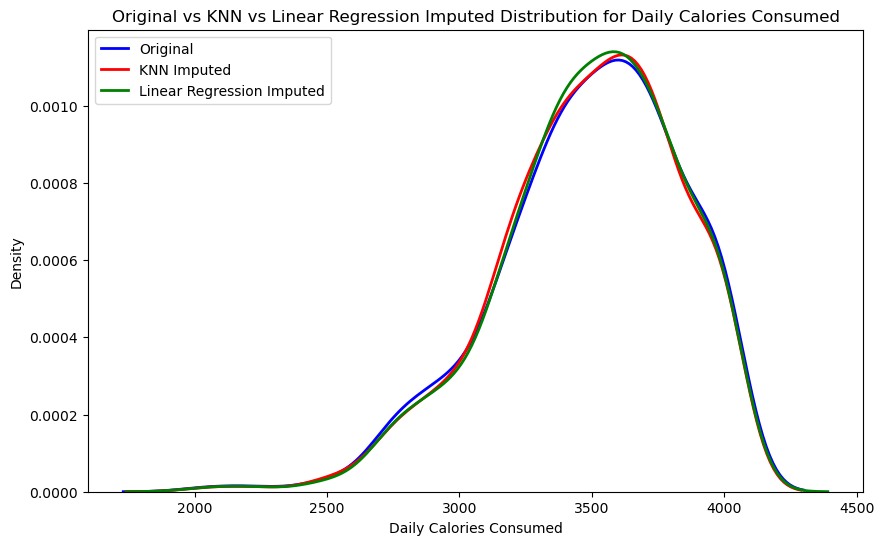

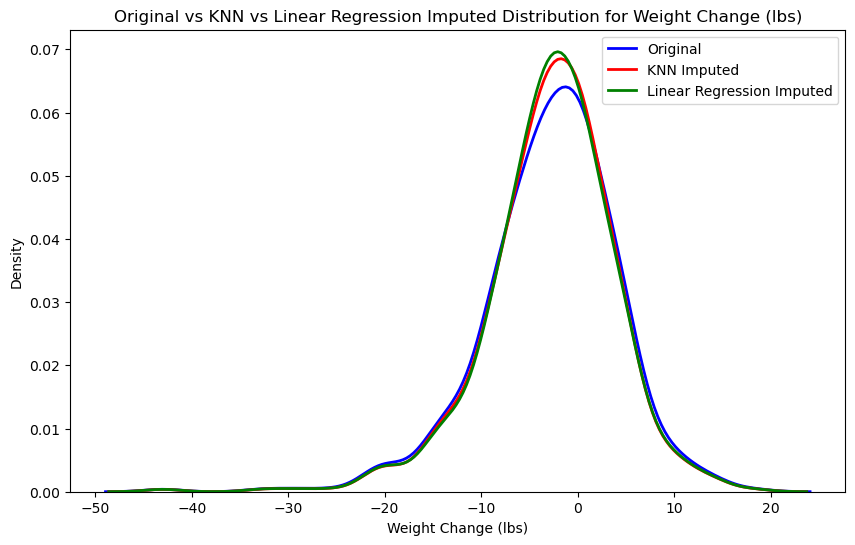

In [23]:
for column in columns_to_impute:
    plt.figure(figsize=(10, 6))
    
    # Plot original distribution (before imputation)
    sns.kdeplot(df[column], color='blue', label='Original', linewidth=2)
    
    # Plot KNN imputed distribution
    sns.kdeplot(df_imputed[column], color='red', label='KNN Imputed', linewidth=2)
    
    # Plot Linear Regression imputed distribution
    sns.kdeplot(df_lr[column], color='green', label='Linear Regression Imputed', linewidth=2)
    
    plt.title(f"Original vs KNN vs Linear Regression Imputed Distribution for {column}")
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Looks like Linear Regression is the best choice, so we will continue with that dataframe

In [24]:
df['Daily Calories Consumed'] = df_lr['Daily Calories Consumed']
df['Weight Change (lbs)'] = df_lr['Weight Change (lbs)']

Removing Outliers

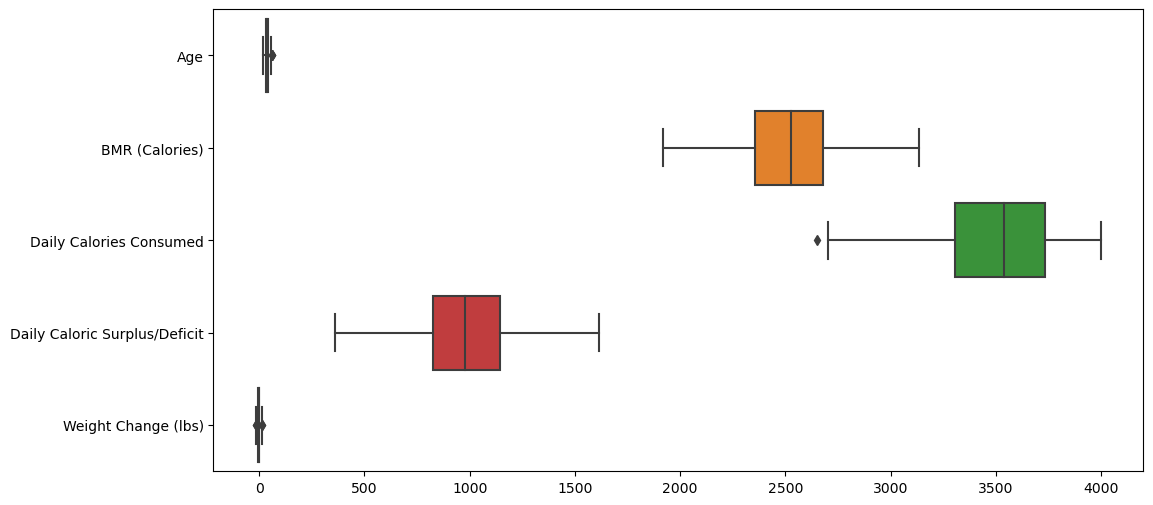

In [25]:
features = ['Age', 'BMR (Calories)', 'Daily Calories Consumed', 'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)']

# Calculate IQR for each feature
Q1 = df[features].quantile(0.25)
Q3 = df[features].quantile(0.75)
IQR = Q3 - Q1

# Define outlier condition (values outside 1.5 * IQR)
outlier_condition = ((df[features] < (Q1 - 1.5 * IQR)) | (df[features] > (Q3 + 1.5 * IQR)))

# Remove rows with outliers
df = df[~outlier_condition.any(axis=1)]


plt.figure(figsize=(12, 6))
sns.boxplot(data=df[features], orient="h")
plt.show()

## 2) Prepare the dataset for a Linear Regression task that aims to build a "Final Weight (lbs)" predictive model.
## (2a) Verify the feature values distribution of the numerical variables.

Plotting the Distributions of continuous features

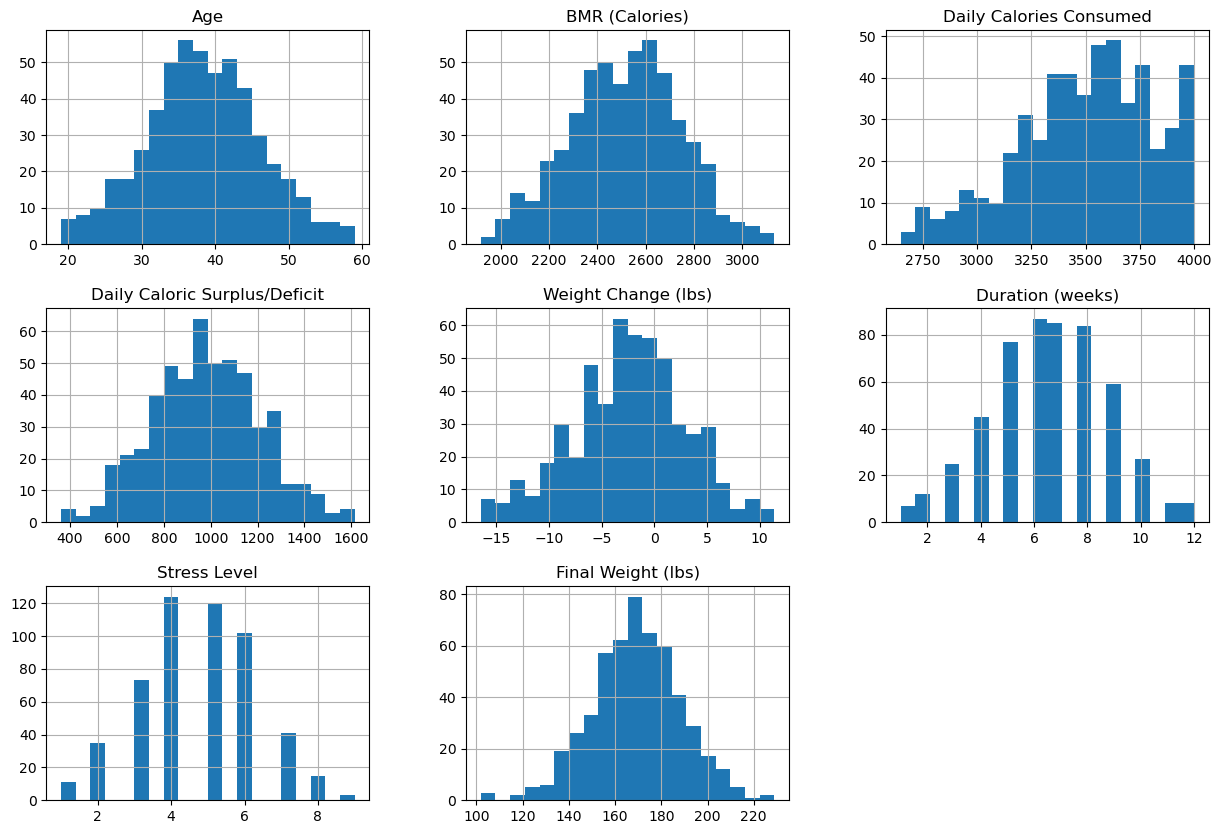

In [26]:
df[continuous_features].hist(bins=20, figsize=(15, 10))
plt.show()

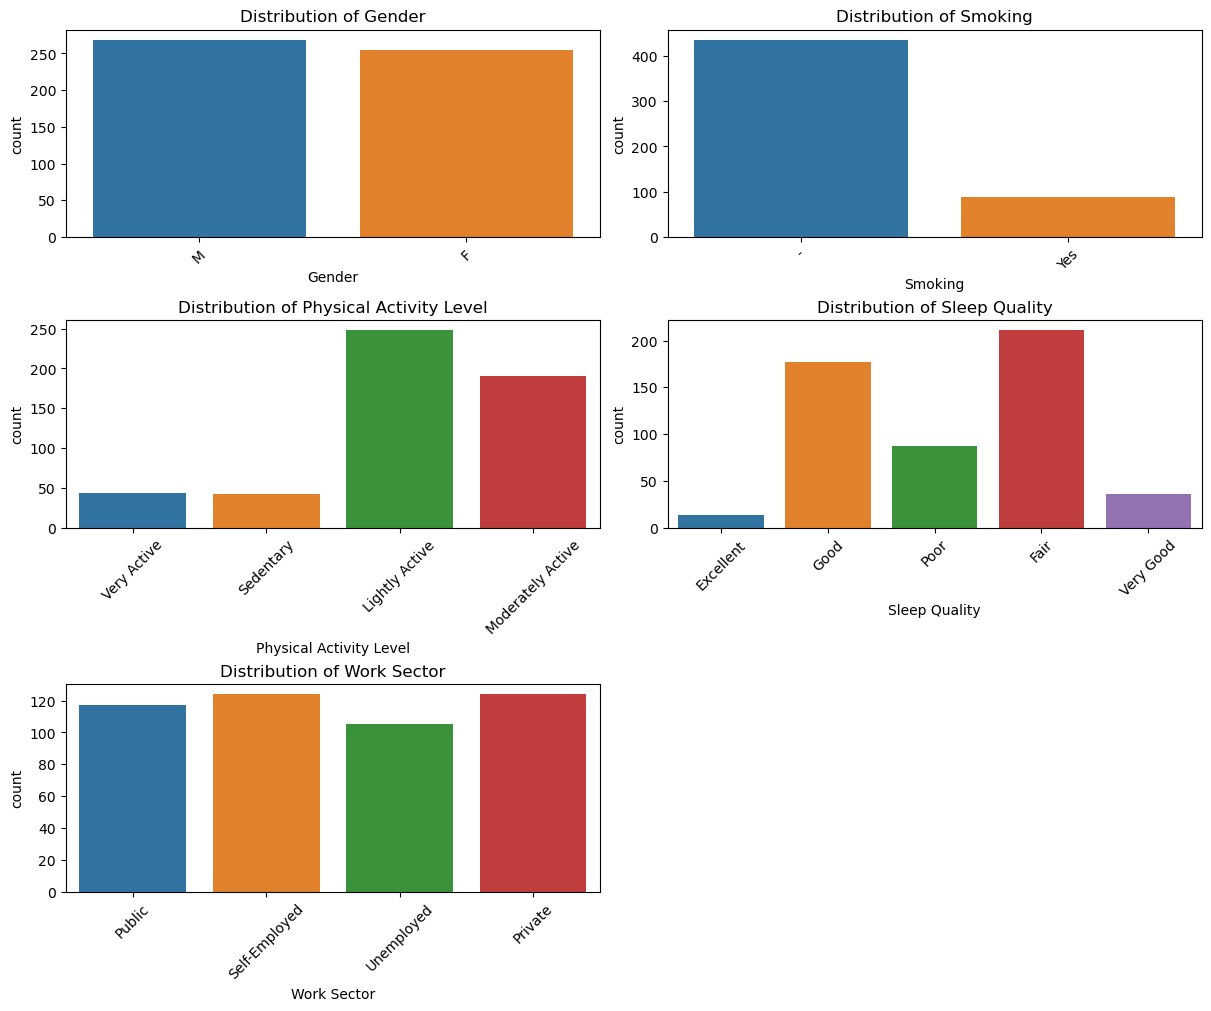

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10), constrained_layout=True)  # 3 rows, 2 columns
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through each feature and create a countplot in a subplot
for i, feature in enumerate(categorical_features):
    sns.countplot(x=feature, data=df, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].tick_params(axis='x', rotation=45) 

# Hide the empty subplot (last subplot on the 3rd row)
axes[-1].set_visible(False)

plt.show()

## (2b) Perform, if necessary, features transformation for the numerical variables, justifying your choices.

Performing Standardization since the dataset does not have extreme outliers. Also it is preferred for linear regression.

Keeping out Final Weight (lbs) since it is the target variable.

In [28]:
# Define the numerical columns to scale
numerical_columns = ['Age', 'BMR (Calories)', 'Daily Calories Consumed', 
                     'Daily Caloric Surplus/Deficit', 'Weight Change (lbs)', 
                     'Duration (weeks)', 'Stress Level']

standard_scaler = StandardScaler()

# Fit and transform the numerical columns with StandardScaler
df[numerical_columns] = standard_scaler.fit_transform(df[numerical_columns])

print(df[numerical_columns].head())


         Age  BMR (Calories)  Daily Calories Consumed  \
1   1.041910       -1.053164                 1.026309   
2  -0.751486       -1.737119                -2.299284   
4   0.017113       -0.228123                -0.608924   
6  -0.239087       -2.298392                -1.824932   
10  1.938608       -1.307730                 0.327281   

    Daily Caloric Surplus/Deficit  Weight Change (lbs)  Duration (weeks)  \
1                        2.460124            -0.027543         -0.260491   
2                       -1.387299             0.666458          0.192988   
4                       -0.588571             1.176397          1.553427   
6                       -0.182224            -1.024642         -2.074409   
10                       1.762220            -0.429111         -0.713971   

    Stress Level  
1       0.852015  
2      -1.055915  
4      -2.327869  
6       0.216038  
10      0.216038  


## (2c) Perform, if necessary, encoding of the categorical variables, justifying your choices.

Encoding for categorical features since its needed to have numerical values to peform linear regression.

Using binary encoding for binary variables: Gender and Smoking

Using Ordinal encoding for ordered categorical variables: Activity level and Sleep quality (this one has a 'Very Good' value that was not mentioned in the assignment instructions)

One-Hot Encoding for nominal variables: Work Sector

In [29]:
# Binary Encoding for binary categorical variables
df['Gender'] = df['Gender'].map({'M': 0, 'F': 1})
df['Smoking'] = df['Smoking'].map({'-': 0, 'Yes': 1})

# Ordinal Encoding for ordered categorical variables with updated mappings
activity_map = {'Sedentary': 0, 'Lightly Active': 1, 'Moderately Active': 2, 'Very Active': 3}
df['Physical Activity Level'] = df['Physical Activity Level'].map(activity_map)

sleep_quality_map = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Very Good': 3,'Excellent': 4}
df['Sleep Quality'] = df['Sleep Quality'].map(sleep_quality_map)

# One-Hot Encoding for nominal categorical variable (Work Sector)
df = pd.get_dummies(df, columns=['Work Sector'], drop_first=True)

# Ensure all one-hot encoded columns are in integer format (0 and 1)
df = df.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

## (2d) Reason about the possibility of decreasing the dimensionality (number of features) of the dataset. Verify if different methodologies of feature selection do choose the same important features: adopt at least a univariate method, an iterative method,and a model-based method exploiting a linear regression model.

Code for Univariate Feature Selection:

In [30]:
# Select top k features using univariate statistical tests
selector = SelectKBest(score_func=f_regression, k='all')  # 'all' means check all features
X = df.drop(columns='Final Weight (lbs)')  # Features
y = df['Final Weight (lbs)']  # Target variable

# Fit selector to the data
selector.fit(X, y)

# Get the scores for each feature
scores = selector.scores_

# Display the feature scores (used later)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})

Code for Recursive Feature Elimination (RFE):

In [31]:
model = LinearRegression()

# Perform RFE with the linear regression model
rfe = RFE(model, n_features_to_select=5)  # Select the top 5 features
X = df.drop(columns='Final Weight (lbs)')  
y = df['Final Weight (lbs)']  

# Fit the RFE model
rfe.fit(X, y)

ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})

Code for Model-Based Feature Selection (Linear Regression Coefficients):

In [32]:
model = LinearRegression()

# Fit the model to the data
X = df.drop(columns='Final Weight (lbs)') 
y = df['Final Weight (lbs)'] 
model.fit(X, y)

# Get the absolute value of the coefficients
coef = pd.DataFrame({'Feature': X.columns, 'Coefficient': np.abs(model.coef_)})

Comparing the results

In [33]:
# Combine results into a single DataFrame
univariate = feature_scores.sort_values(by='Score', ascending=False).head(14)
rfe = ranking.sort_values(by='Ranking').head(14)
coef = coef.sort_values(by='Coefficient', ascending=False).head(14)

# Display the top 10 features from each method
print("Top 10 features by Univariate Test:")
print(univariate)

print("\nTop 10 features by RFE:")
print(rfe)

print("\nTop 10 features by Linear Regression Coefficients:")
print(coef)

Top 10 features by Univariate Test:
                          Feature        Score
2                  BMR (Calories)  2238.841936
3         Daily Calories Consumed   350.180995
10                   Stress Level     9.519618
9                   Sleep Quality     7.282827
5             Weight Change (lbs)     4.738140
13         Work Sector_Unemployed     2.537577
4   Daily Caloric Surplus/Deficit     1.153027
8         Physical Activity Level     0.424805
0                             Age     0.335577
7                         Smoking     0.124234
12      Work Sector_Self-Employed     0.117249
11             Work Sector_Public     0.004097
6                Duration (weeks)     0.002826
1                          Gender     0.001411

Top 10 features by RFE:
                          Feature  Ranking
0                             Age        1
2                  BMR (Calories)        1
3         Daily Calories Consumed        1
4   Daily Caloric Surplus/Deficit        1
5             Weigh

The results show that the lowest ranks are from Physical Activity Level, Work Sector_Self-Employed, Duration (weeks), Work Sector_Unemployed and Work Sector_Public so those features will be dropped.

Gender is required in future tasks so it is not removed from the dataset.

In [34]:
df = df.drop(columns=['Physical Activity Level', 'Work Sector_Self-Employed', 'Duration (weeks)', 'Work Sector_Unemployed', 'Work Sector_Public'])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 524 entries, 1 to 575
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            524 non-null    float64
 1   Gender                         524 non-null    int64  
 2   BMR (Calories)                 524 non-null    float64
 3   Daily Calories Consumed        524 non-null    float64
 4   Daily Caloric Surplus/Deficit  524 non-null    float64
 5   Weight Change (lbs)            524 non-null    float64
 6   Smoking                        524 non-null    int64  
 7   Sleep Quality                  524 non-null    int64  
 8   Stress Level                   524 non-null    float64
 9   Final Weight (lbs)             524 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 45.0 KB


## (2e) On the base of the analysis performed above, define a dataset that you will exploit in the rest of the project (dataset_reduced), for the supervised task.

In [36]:
df.to_csv('dataset_reduced.csv', index=False)

In [37]:
df = pd.read_csv('dataset_reduced.csv')
display(df.head())

,Age,Gender,BMR (Calories),Daily Calories Consumed,Daily Caloric Surplus/Deficit,Weight Change (lbs),Smoking,Sleep Quality,Stress Level,Final Weight (lbs)
0,1.041910,0,-1.053164,1.026309,2.460124,-0.027543,0,4,0.852015,167.8
1,-0.751486,0,-1.737119,-2.299284,-1.387299,0.666458,1,2,-1.055915,144.2
2,0.017113,0,-0.228123,-0.608924,-0.588571,1.176397,0,2,-2.327869,157.5
3,-0.239087,0,-2.298392,-1.824932,-0.182224,-1.024642,0,0,0.216038,104.9
4,1.938608,0,-1.307730,0.327281,1.762220,-0.429111,0,4,0.216038,140.4


## 3. Build a supervised system based on Linear Regression capable of predicting the Final Weight (lbs) under the two conditions specified in the preamble (per-form the following tasks for both conditions separately). Implement different approaches:
## (3a) Linear Regression exploiting the sklearn implementation of the algorithm.

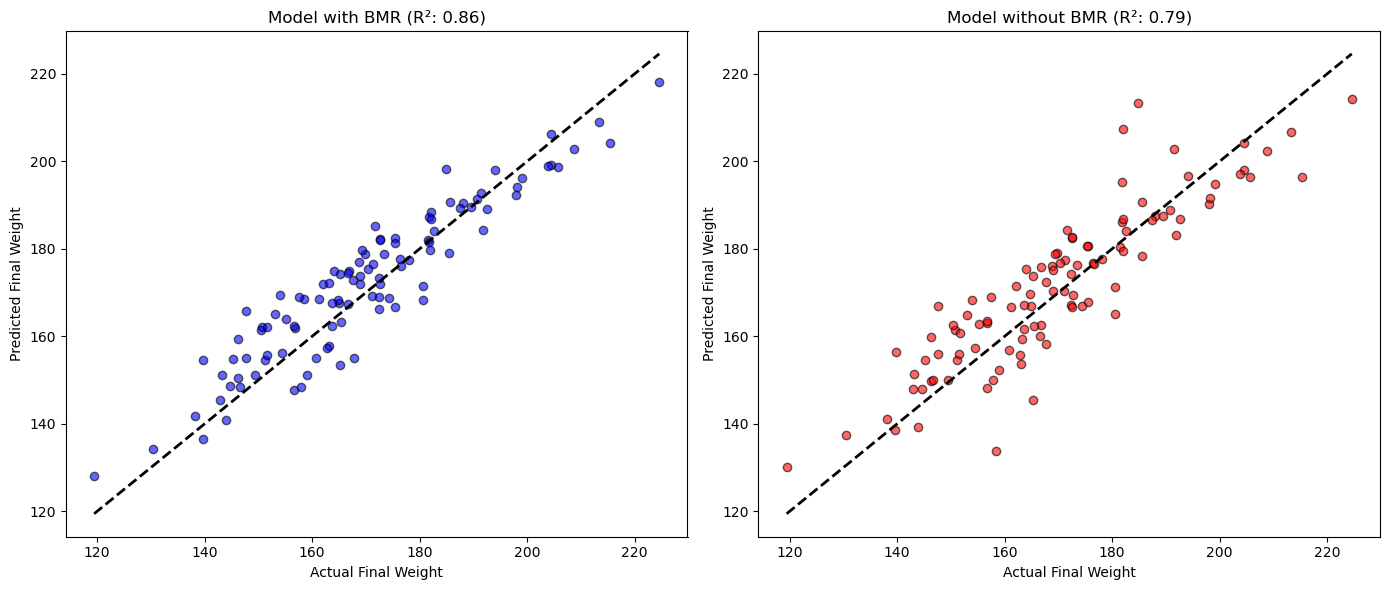

Model with BMR:
MSE: 52.791637709113346
R² Score: 0.8590272667760868

Model without BMR:
MSE: 80.46442112937756
R² Score: 0.7851309437227372


In [38]:
# Split the dataset into features and target
X = df.drop(columns=['Final Weight (lbs)']) 
y = df['Final Weight (lbs)']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model 1: Including Calories
X_train_with_calories = X_train
X_test_with_calories = X_test

# Without Calories
X = df.drop(columns=['Final Weight (lbs)', 'BMR (Calories)'])  # All features except the target and BMR
y = df['Final Weight (lbs)']

# Split the dataset into training and testing sets
X_train_without_calories, X_test_without_calories, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_with_calories = LinearRegression()
model_without_calories = LinearRegression()

# Train the model with Calories
model_with_calories.fit(X_train_with_calories, y_train)
y_pred_with_calories = model_with_calories.predict(X_test_with_calories)

# Train the model without Calories
model_without_calories.fit(X_train_without_calories, y_train)
y_pred_without_calories = model_without_calories.predict(X_test_without_calories)

# Calculate metrics for both models
mse_with_calories = mean_squared_error(y_test, y_pred_with_calories)
r2_with_calories = r2_score(y_test, y_pred_with_calories)

mse_without_calories = mean_squared_error(y_test, y_pred_without_calories)
r2_without_calories = r2_score(y_test, y_pred_without_calories)


plt.figure(figsize=(14, 6))

# Plot for Model with Calories
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_with_calories, color="blue", alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Final Weight")
plt.ylabel("Predicted Final Weight")
plt.title(f"Model with BMR (R²: {r2_with_calories:.2f})")

# Plot for Model without Calories
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_without_calories, color="red", alpha=0.6, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Final Weight")
plt.ylabel("Predicted Final Weight")
plt.title(f"Model without BMR (R²: {r2_without_calories:.2f})")

plt.tight_layout()
plt.show()

print("Model with BMR:")
print(f"MSE: {mse_with_calories}")
print(f"R² Score: {r2_with_calories}")

print("\nModel without BMR:")
print(f"MSE: {mse_without_calories}")
print(f"R² Score: {r2_without_calories}")

The model with BMR consistently outperforms the model without it, achieving both a higher R² score and a lower MSE, and showing better alignment with actual values in the plot.

## (3b) Linear Regression exploiting a Batch Gradient Descent learning procedure (not the sklearn implementation). Identify the best value of learning rate 𝜂 and an appropriate number of iterations which ensures the convergence of the model.

In [39]:
def batch_gradient_descent(X, y, learning_rate=0.01, iterations=1000, tolerance=1e-6):
    m, n = X.shape
    theta = np.zeros(n)  # Initialize weights
    cost_history = []    # To keep track of cost at each iteration
    
    # Perform gradient descent
    for i in range(iterations):
        y_pred = X.dot(theta)
        error = y_pred - y
        gradient = (1/m) * X.T.dot(error)
        theta -= learning_rate * gradient
        cost = (1/(2*m)) * np.sum(error ** 2)
        cost_history.append(cost)
        
        # Check for convergence
        if i > 0 and abs(cost_history[-2] - cost) < tolerance:
            break
    
    return theta, cost_history

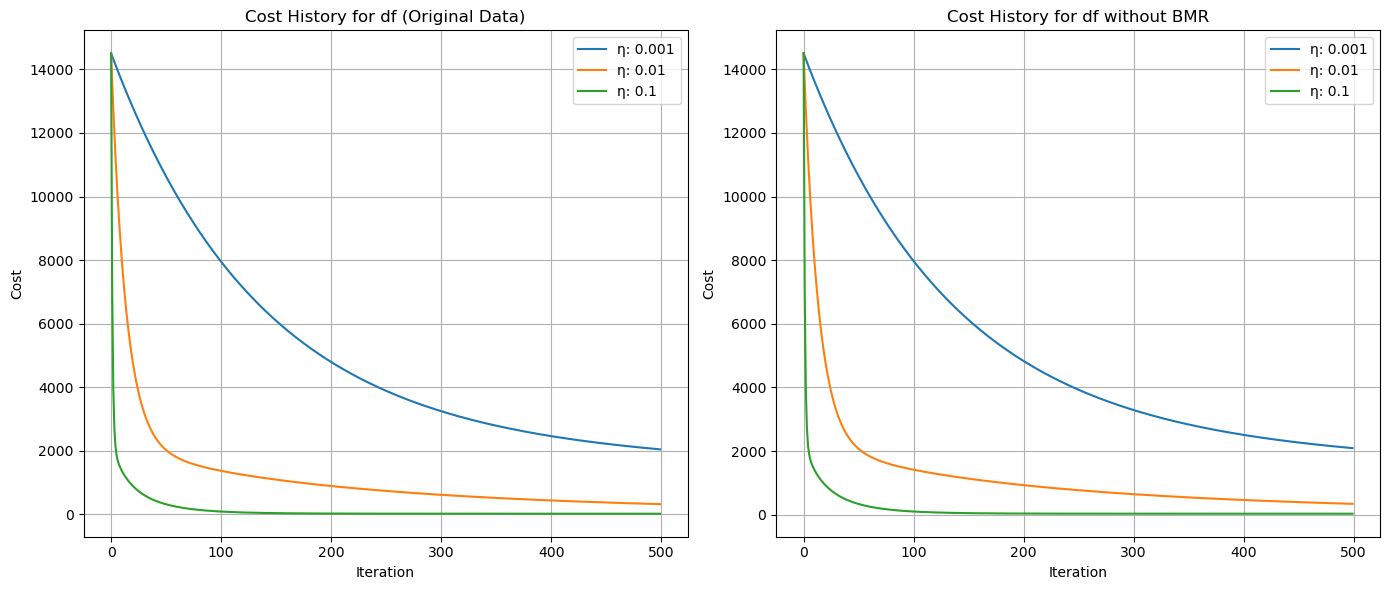


Final Costs for df: {0.001: 2047.9968801411862, 0.01: 324.71297602026226, 0.1: 24.083382583500352}
Best learning rate for df: 0.1

Final Costs for df without BMR: {0.001: 2094.3663836819683, 0.01: 342.5335386156523, 0.1: 32.41335718882665}
Best learning rate for df without BMR: 0.1


In [40]:
# Prepare the data for the original DataFrame
X = df.drop(columns=["Final Weight (lbs)"]).values 
y = df["Final Weight (lbs)"].values                 
X = np.c_[np.ones(X.shape[0]), X]   # Add intercept term

# Tuning learning rate and iterations
learning_rates = [0.001, 0.01, 0.1]
iterations = 500

# Dictionary to store cost histories for each learning rate
cost_histories_1 = {}

for lr in learning_rates:
    theta, cost_history = batch_gradient_descent(X, y, learning_rate=lr, iterations=iterations)
    cost_histories_1[lr] = cost_history

# Prepare the data for the second DataFrame (no BMR)
X = df.drop(columns=["Final Weight (lbs)", 'BMR (Calories)']).values 
y = df["Final Weight (lbs)"].values               
X = np.c_[np.ones(X.shape[0]), X]   # Add intercept term

cost_histories_2 = {}

for lr in learning_rates:
    theta, cost_history = batch_gradient_descent(X, y, learning_rate=lr, iterations=iterations)
    cost_histories_2[lr] = cost_history

# Plotting the cost histories for both data sets side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  

# First plot for df
for lr, cost_history in cost_histories_1.items():
    ax[0].plot(cost_history, label=f'η: {lr}')

ax[0].set_title("Cost History for df (Original Data)")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Cost")
ax[0].legend()
ax[0].grid()

# Second plot for df without BMR
for lr, cost_history in cost_histories_2.items():
    ax[1].plot(cost_history, label=f'η: {lr}')

ax[1].set_title("Cost History for df without BMR")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Cost")
ax[1].legend()
ax[1].grid()

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

# Print final costs and determine the best learning rate for each dataset
final_costs_df = {lr: history[-1] for lr, history in cost_histories_1.items()}
final_costs_df_no_bmr = {lr: history[-1] for lr, history in cost_histories_2.items()}

best_lr_df = min(final_costs_df, key=final_costs_df.get)
best_lr_df_no_bmr = min(final_costs_df_no_bmr, key=final_costs_df_no_bmr.get)

print("\nFinal Costs for df:", final_costs_df)
print("Best learning rate for df:", best_lr_df)
print("\nFinal Costs for df without BMR:", final_costs_df_no_bmr)
print("Best learning rate for df without BMR:", best_lr_df_no_bmr)


The inclusion of BMR as a feature helps the model achieve: a lower final costs, indicating better accuracy and fit, faster convergence with a high learning rate, where the model with BMR reaches a lower cost plateau faster and at a lower value than the model without BMR.

0.1 is the best learning rate.

## (3c) Linear Regression exploiting a Mini-Batch Gradient Descent learning procedure (not the sklearn implementation), exploiting a mini-batch size of maximum 128 samples (use mini-batch sizes as power of 2). Identify the best value of learning rate 𝜂 and an appropriate number of iterations which ensures the convergence of the model.

In [41]:
# Define the Mini-Batch Gradient Descent function with MSE cost calculation
def mini_batch_gradient_descent(X, y, learning_rate=0.01, batch_size=32, iterations=1000, tolerance=1e-6):
    m, n = X.shape
    theta = np.zeros(n)  
    mse_history = []     # To keep track of MSE at each iteration

    for i in range(iterations):
        # Shuffle the data at each iteration
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        # Loop over mini-batches
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_shuffled[start:end]
            y_batch = y_shuffled[start:end]

            # Compute predictions and error for the mini-batch
            y_pred = X_batch.dot(theta)
            error = y_pred - y_batch
            gradient = (1 / X_batch.shape[0]) * X_batch.T.dot(error)
            theta -= learning_rate * gradient

        # Calculate and save MSE for the current iteration
        y_pred_full = X.dot(theta)
        mse = (1 / m) * np.sum((y_pred_full - y) ** 2)
        mse_history.append(mse)

        # Check for convergence
        if i > 0 and abs(mse_history[-2] - mse) < tolerance:
            break

    return theta, mse_history

Picking the best learning rate for each batch size

Best learning rate for batch size 2 in df = 0.001 with final MSE = 48.04787102391504
Best learning rate for batch size 4 in df = 0.001 with final MSE = 48.1523808101923
Best learning rate for batch size 8 in df = 0.001 with final MSE = 50.22852579217681
Best learning rate for batch size 16 in df = 0.001 with final MSE = 106.21237203626991
Best learning rate for batch size 32 in df = 0.001 with final MSE = 392.3594337004945
Best learning rate for batch size 64 in df = 0.001 with final MSE = 1005.7652835606656
Best learning rate for batch size 128 in df = 0.001 with final MSE = 1796.5171729960834
Best learning rate for batch size 2 in df without BMR = 0.001 with final MSE = 64.82484466519949
Best learning rate for batch size 4 in df without BMR = 0.001 with final MSE = 64.82488990429553
Best learning rate for batch size 8 in df without BMR = 0.001 with final MSE = 66.7252969871796
Best learning rate for batch size 16 in df without BMR = 0.001 with final MSE = 122.94815805119813
Best lear

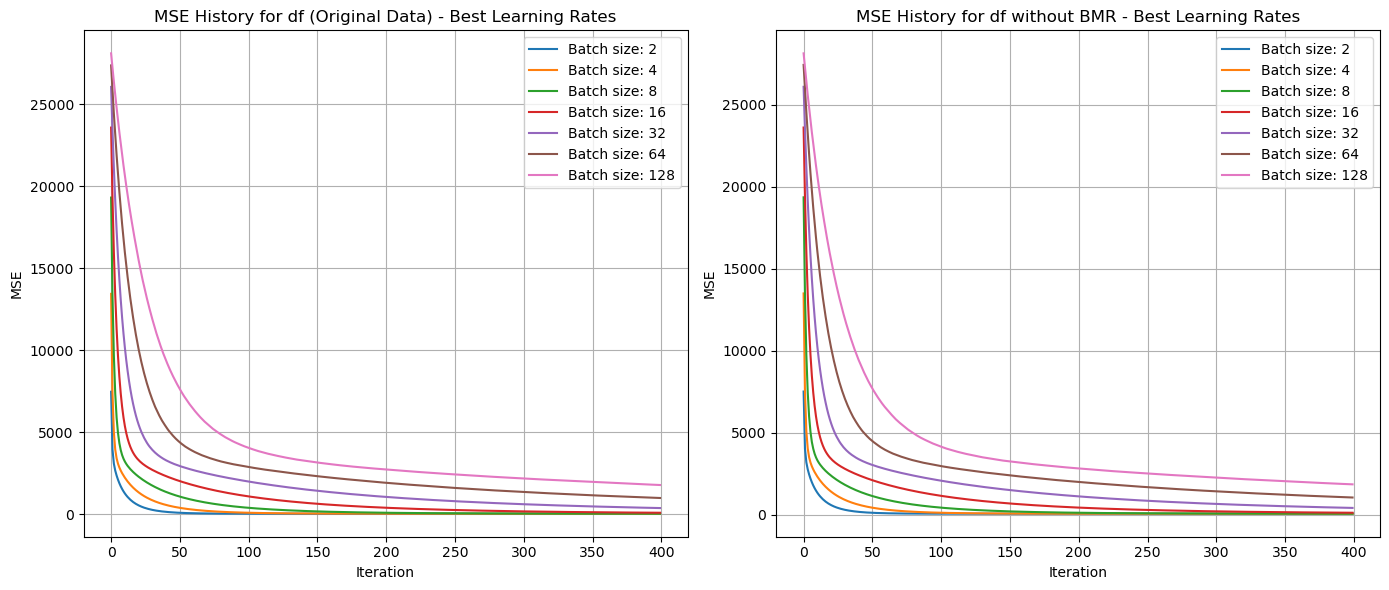

In [42]:
# Prepare the data for the original DataFrame 
X_df = df.drop(columns=["Final Weight (lbs)"]).values  
y_df = df["Final Weight (lbs)"].values                 
X_df = np.c_[np.ones(X_df.shape[0]), X_df]             

# Tuning learning rates and batch sizes
learning_rates = [0.0001, 0.001]
batch_sizes = [2, 4, 8, 16, 32, 64, 128]
iterations = 400

# Run mini-batch gradient descent on original data 
best_mse_histories_df = {}
for batch_size in batch_sizes:
    best_lr = None
    best_mse_history = None
    lowest_final_mse = float('inf')
    for lr in learning_rates:
        theta, mse_history = mini_batch_gradient_descent(X_df, y_df, learning_rate=lr, batch_size=batch_size, iterations=iterations)
        final_mse = mse_history[-1]
        if final_mse < lowest_final_mse:
            lowest_final_mse = final_mse
            best_lr = lr
            best_mse_history = mse_history
    best_mse_histories_df[batch_size] = best_mse_history
    print(f"Best learning rate for batch size {batch_size} in df = {best_lr} with final MSE = {lowest_final_mse}")

# Prepare the data for the second DataFrame (df_noBMR)
X_df_no_bmr = df.drop(columns=["Final Weight (lbs)", 'BMR (Calories)']).values 
y_df_no_bmr = df["Final Weight (lbs)"].values                                  
X_df_no_bmr = np.c_[np.ones(X_df_no_bmr.shape[0]), X_df_no_bmr]                 

# Run mini-batch gradient descent on data without BMR
best_mse_histories_df_no_bmr = {}
for batch_size in batch_sizes:
    best_lr = None
    best_mse_history = None
    lowest_final_mse = float('inf')
    for lr in learning_rates:
        theta, mse_history = mini_batch_gradient_descent(X_df_no_bmr, y_df_no_bmr, learning_rate=lr, batch_size=batch_size, iterations=iterations)
        final_mse = mse_history[-1]
        if final_mse < lowest_final_mse:
            lowest_final_mse = final_mse
            best_lr = lr
            best_mse_history = mse_history
    best_mse_histories_df_no_bmr[batch_size] = best_mse_history
    print(f"Best learning rate for batch size {batch_size} in df without BMR = {best_lr} with final MSE = {lowest_final_mse}")

# Plotting MSE histories for both datasets with only the best learning rate for each batch size
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for df (with BMR)
for batch_size, mse_history in best_mse_histories_df.items():
    ax[0].plot(mse_history, label=f'Batch size: {batch_size}')
ax[0].set_title("MSE History for df (Original Data) - Best Learning Rates")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MSE")
ax[0].legend()
ax[0].grid()

# Plot for df (without BMR)
for batch_size, mse_history in best_mse_histories_df_no_bmr.items():
    ax[1].plot(mse_history, label=f'Batch size: {batch_size}')
ax[1].set_title("MSE History for df without BMR - Best Learning Rates")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("MSE")
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

The model with BMR is more accurate

Smaller batch sizes (especially 2 and 4) consistently yield the best performance. Larger batch sizes result in higher MSE values and slower convergence.

## (3d) Consider the complete dataset and eventually add interaction or polynomial features (dataset_augmented). With this dataset, train a new Linear regression model based on a Batch Gradient Descent learning procedure (not the sklearn implementation). Identify the best value of learning rate 𝜂 and an appropriate number of iterations which ensures the convergence of the model.

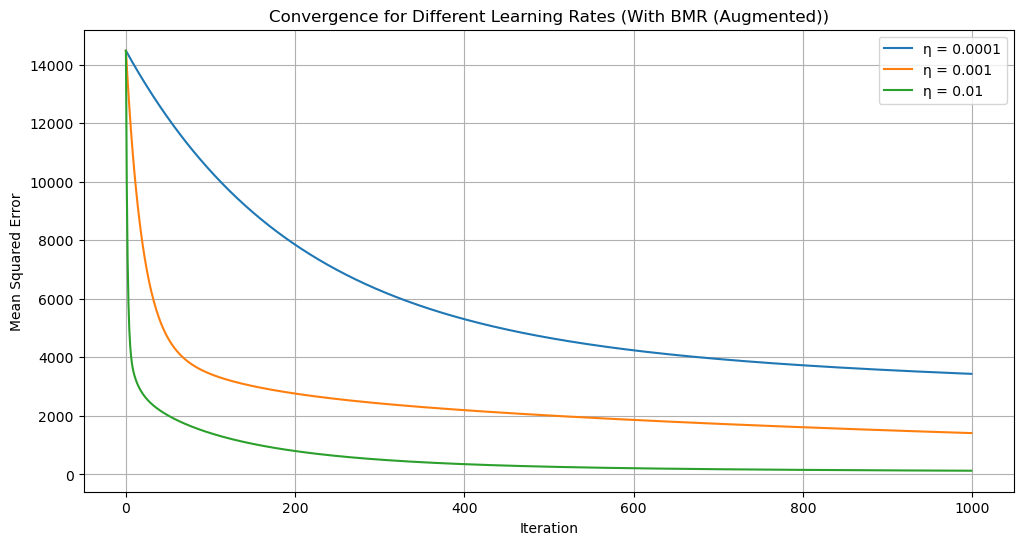


Batch Gradient Descent Results (With BMR (Augmented)):
--------------------------------------------------
Best Learning Rate: 0.01
Training RMSE: 15.94
Testing RMSE: 17.75
Training R² Score: 0.2981
Testing R² Score: 0.1586


<Figure size 640x480 with 0 Axes>

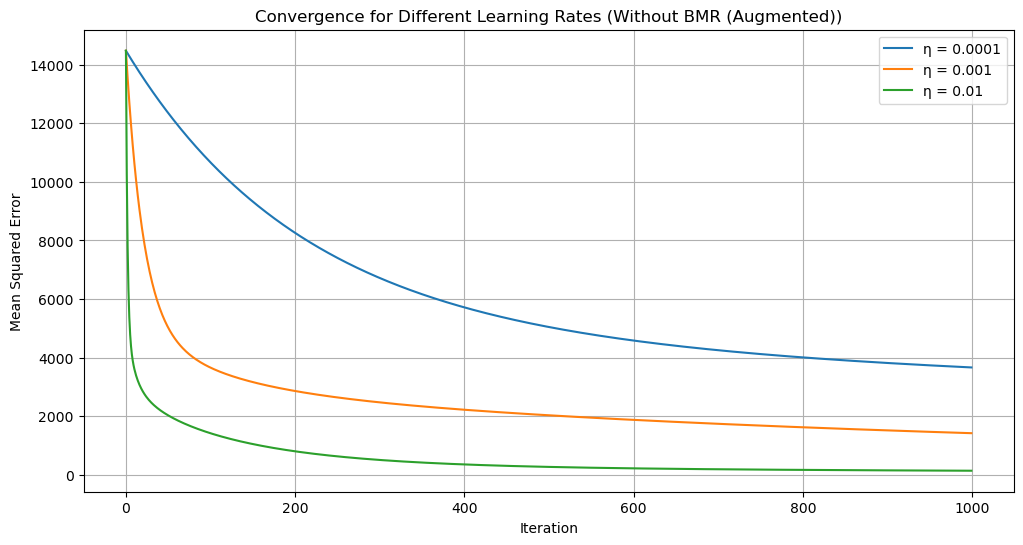


Batch Gradient Descent Results (Without BMR (Augmented)):
--------------------------------------------------
Best Learning Rate: 0.01
Training RMSE: 16.56
Testing RMSE: 19.30
Training R² Score: 0.2417
Testing R² Score: 0.0048


<Figure size 640x480 with 0 Axes>

In [43]:
# Define the batch gradient descent function
def batch_gradient_descent_bias(X, y, learning_rate, n_iterations):
    weights = np.zeros(X.shape[1])
    bias = 0
    m = len(y)
    cost_history = []
    
    for i in range(n_iterations):
        y_pred = np.dot(X, weights) + bias
        dw = (1/m) * np.dot(X.T, (y_pred - y))
        db = (1/m) * np.sum(y_pred - y)
        weights -= learning_rate * dw
        bias -= learning_rate * db
        cost = (1/(2*m)) * np.sum((y_pred - y)**2)
        cost_history.append(cost)
        
    return weights, bias, cost_history

# Load the dataset and create polynomial and interaction features
dataset_augmented = df.copy()
X_with_bmr = dataset_augmented.drop(columns=["Final Weight (lbs)"]).values
X_without_bmr = dataset_augmented.drop(columns=["Final Weight (lbs)", "BMR (Calories)"]).values
y = dataset_augmented["Final Weight (lbs)"].values

# Define the degree of polynomial features 
poly = PolynomialFeatures(degree=2, include_bias=False)
X_with_bmr_aug = poly.fit_transform(X_with_bmr)
X_without_bmr_aug = poly.fit_transform(X_without_bmr)

X_train_with_bmr, X_test_with_bmr, y_train, y_test = train_test_split(X_with_bmr_aug, y, test_size=0.2, random_state=42)
X_train_without_bmr, X_test_without_bmr = train_test_split(X_without_bmr_aug, test_size=0.2, random_state=42)

learning_rates = [0.0001, 0.001, 0.01]
n_iterations = 1000

# Helper function to train and evaluate the model on a specific dataset
def train_and_evaluate(X_train, X_test, y_train, y_test, label):
    plt.figure(figsize=(12, 6))
    best_cost = float('inf')
    best_lr = None
    best_weights = None
    best_bias = None

    for lr in learning_rates:
        weights, bias, cost_history = batch_gradient_descent_bias(X_train, y_train, lr, n_iterations)
        plt.plot(cost_history, label=f'η = {lr}')
        
        if cost_history[-1] < best_cost:
            best_cost = cost_history[-1]
            best_lr = lr
            best_weights = weights
            best_bias = bias

    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.title(f'Convergence for Different Learning Rates ({label})')
    plt.legend()
    plt.grid(True)
    plt.show()

    y_pred_train = np.dot(X_train, best_weights) + best_bias
    y_pred_test = np.dot(X_test, best_weights) + best_bias

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    print(f"\nBatch Gradient Descent Results ({label}):")
    print("-" * 50)
    print(f"Best Learning Rate: {best_lr}")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Testing RMSE: {test_rmse:.2f}")
    print(f"Training R² Score: {train_r2:.4f}")
    print(f"Testing R² Score: {test_r2:.4f}")
    plt.tight_layout()
    plt.show()

train_and_evaluate(X_train_with_bmr, X_test_with_bmr, y_train, y_test, label="With BMR (Augmented)")
train_and_evaluate(X_train_without_bmr, X_test_without_bmr, y_train, y_test, label="Without BMR (Augmented)")


A learning rate of 0.01 is optimal for both models

The model with BMR achieves better generalization, as indicated by the higher testing R² and lower testing RMSE



## (3e) Compare the related learning curve of the Gradient Descent-based approaches developed above and comment both on the learning procedure and on the generalization performances of the model.

In [44]:
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def batch_gradient_descent(X, y, learning_rate=0.01, iterations=1000):
    m = len(y)
    theta = np.zeros(X.shape[1])
    costs = []

    for i in range(iterations):
        predictions = X.dot(theta)
        error = predictions - y
        cost = mean_squared_error(y, predictions)
        costs.append(cost)
        gradient = (1 / m) * X.T.dot(error)
        theta -= learning_rate * gradient

    return theta, costs

def mini_batch_gradient_descent(X, y, learning_rate=0.01, iterations=1000, batch_size=32):
    m = len(y)
    theta = np.zeros(X.shape[1])
    costs = []

    for i in range(iterations):
        cost = 0.0
        for start in range(0, m, batch_size):
            end = min(start + batch_size, m)
            X_batch = X[start:end]
            y_batch = y[start:end]
            predictions = X_batch.dot(theta)
            error = predictions - y_batch
            cost += mean_squared_error(y_batch, predictions)
            gradient = (1 / len(y_batch)) * X_batch.T.dot(error)
            theta -= learning_rate * gradient
        costs.append(cost / (m // batch_size))

    return theta, costs

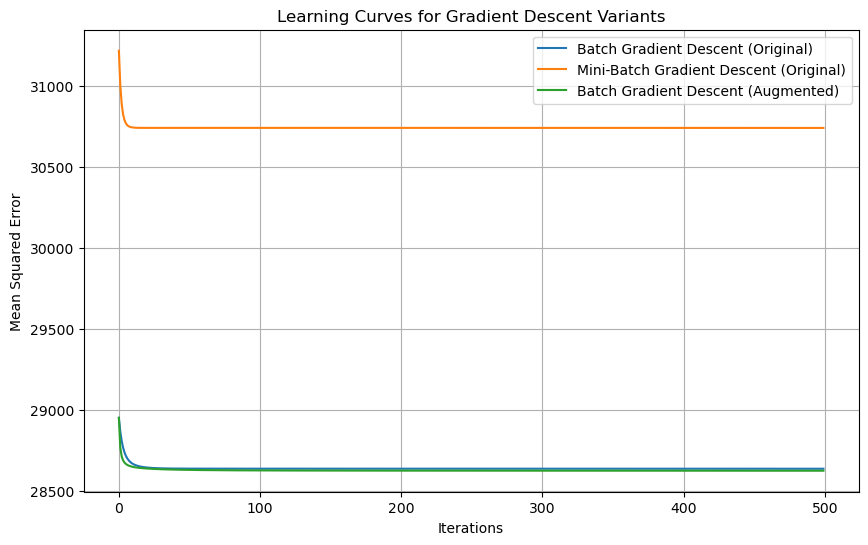

In [45]:
X = df.drop(columns=["Final Weight (lbs)"]).values  
y = df["Final Weight (lbs)"].values                 

# Augment dataset with polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_augmented = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train_aug = scaler.fit_transform(X_train_aug)
X_test_aug = scaler.transform(X_test_aug)

learning_rate = 0.1
iterations = 500

_, batch_costs = batch_gradient_descent(X_train, y_train, learning_rate, iterations)
_, mini_batch_costs = mini_batch_gradient_descent(X_train, y_train, 0.01, iterations, batch_size=32)
_, batch_costs_augmented = batch_gradient_descent(X_train_aug, y_train_aug, learning_rate, iterations)

plt.figure(figsize=(10, 6))
plt.plot(batch_costs, label="Batch Gradient Descent (Original)")
plt.plot(mini_batch_costs, label="Mini-Batch Gradient Descent (Original)")
plt.plot(batch_costs_augmented, label="Batch Gradient Descent (Augmented)")
plt.xlabel("Iterations")
plt.ylabel("Mean Squared Error")
plt.title("Learning Curves for Gradient Descent Variants")
plt.legend()
plt.grid(True)
plt.show()

•	Batch Gradient Descent (3b) with a higher learning rate (η = 0.1) achieves stable convergence and a low final cost but requires processing the entire dataset for each update, which is computationally intensive.

•	Mini-Batch Gradient Descent (3c) with smaller batch sizes (e.g., 2, 4, or 8) strikes a balance between convergence speed and stability, achieving lower final MSEs compared to larger batch sizes. This suggests that a mini-batch approach with smaller batch sizes is advantageous for this dataset.

•	Augmented Batch Gradient Descent (3d), with feature augmentation, improves RMSE and R² scores modestly, suggesting feature engineering does aid in capturing variance, though the model’s linear nature might still limit its predictive power.

In general, Mini-Batch Gradient Descent with a smaller batch size (like 4 or 8) and a moderate learning rate seems optimal for this dataset, balancing convergence speed and stability while leveraging stochastic updates for better generalization.

## (3f) With the dataset generated in the task above (dataset_augmented), train a Linear Regression model with Lasso regularization. Comment on the importance of each feature and reason over the number of features selected with different values of 𝛼. Verify how the model performances change with different values of 𝛼 (different number of features). Use a plot of your choice.

Lasso Analysis for Dataset with BMR - Augmented


/Users/alessiocarnevale/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.493e+03, tolerance: 1.910e+01
  model = cd_fast.enet_coordinate_descent(
/Users/alessiocarnevale/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.837e+01, tolerance: 1.910e+01
  model = cd_fast.enet_coordinate_descent(


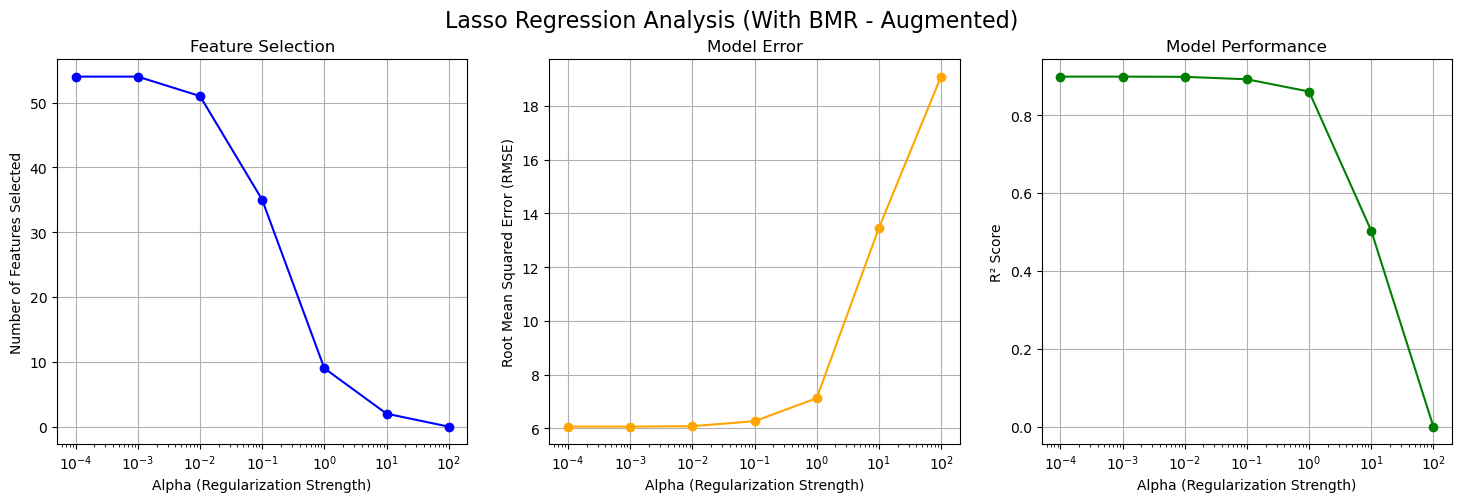


Lasso Analysis for Dataset without BMR - Augmented)


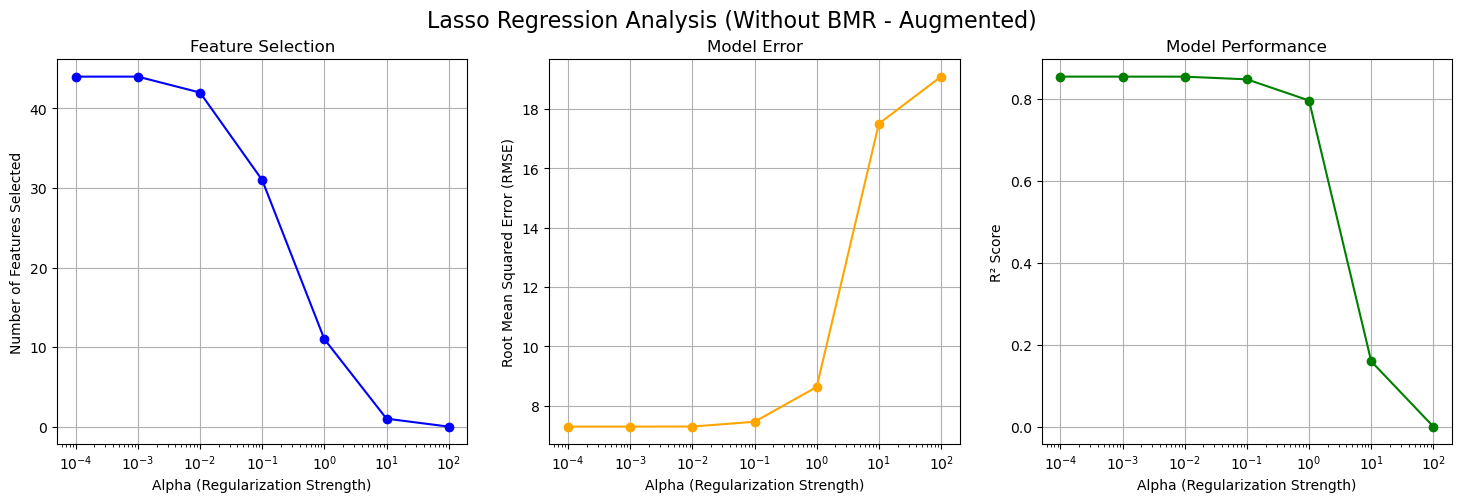

In [46]:
# Define the Lasso analysis function with improved plotting
def lasso_analysis(X_augmented, y_augmented, alpha_values, label):
    coef_path = []
    rmse_values = []
    r2_values = []
    num_features_selected = []

    # Iterate over different alpha values
    for alpha in alpha_values:
        # Initialize and fit Lasso model
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_augmented, y_augmented)
        
        # Record coefficients, RMSE, and R²
        coef_path.append(lasso.coef_)
        y_pred = lasso.predict(X_augmented)
        rmse_values.append(np.sqrt(mean_squared_error(y_augmented, y_pred)))
        r2_values.append(r2_score(y_augmented, y_pred))
        num_features_selected.append(np.sum(lasso.coef_ != 0))

    # Convert coef_path to a numpy array for easier indexing
    coef_path = np.array(coef_path)

    # Set up subplots for clearer visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Lasso Regression Analysis ({label})', fontsize=16)

    # Plot 1: Number of Features Selected vs Alpha
    axes[0].plot(alpha_values, num_features_selected, marker='o', color='b')
    axes[0].set_xscale('log')
    axes[0].set_xlabel("Alpha (Regularization Strength)")
    axes[0].set_ylabel("Number of Features Selected")
    axes[0].set_title("Feature Selection")
    axes[0].grid(True)

    # Plot 2: RMSE vs. Alpha
    axes[1].plot(alpha_values, rmse_values, marker='o', color='orange')
    axes[1].set_xscale('log')
    axes[1].set_xlabel("Alpha (Regularization Strength)")
    axes[1].set_ylabel("Root Mean Squared Error (RMSE)")
    axes[1].set_title("Model Error")
    axes[1].grid(True)

    # Plot 3: R² Score vs Alpha
    axes[2].plot(alpha_values, r2_values, marker='o', color='green')
    axes[2].set_xscale('log')
    axes[2].set_xlabel("Alpha (Regularization Strength)")
    axes[2].set_ylabel("R² Score")
    axes[2].set_title("Model Performance")
    axes[2].grid(True)

    plt.show()

alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Perform Lasso analysis on the dataset with BMR
print("Lasso Analysis for Dataset with BMR - Augmented")
lasso_analysis(X_with_bmr_aug, y, alpha_values, label="With BMR - Augmented")

# Perform Lasso analysis on the dataset without BMR
print("\nLasso Analysis for Dataset without BMR - Augmented)")
lasso_analysis(X_without_bmr_aug, y, alpha_values, label="Without BMR - Augmented")

Increasing alpha in Lasso regression reduces the number of active features, increases RMSE, and lowers the R² score, showing a trade-off between model complexity and generalization.

The model starts to underfit with values of alpha greater than 1

## (3g) With the complete dataset generated above (dataset_augmented), train a Ridge Regression model identifying the best value of the regularization coeffi-cient 𝜶 that allows the model to achieve the best generalization performances. Evaluate the generalization performances of the model.

Ridge Analysis for Dataset with BMR (Augmented)


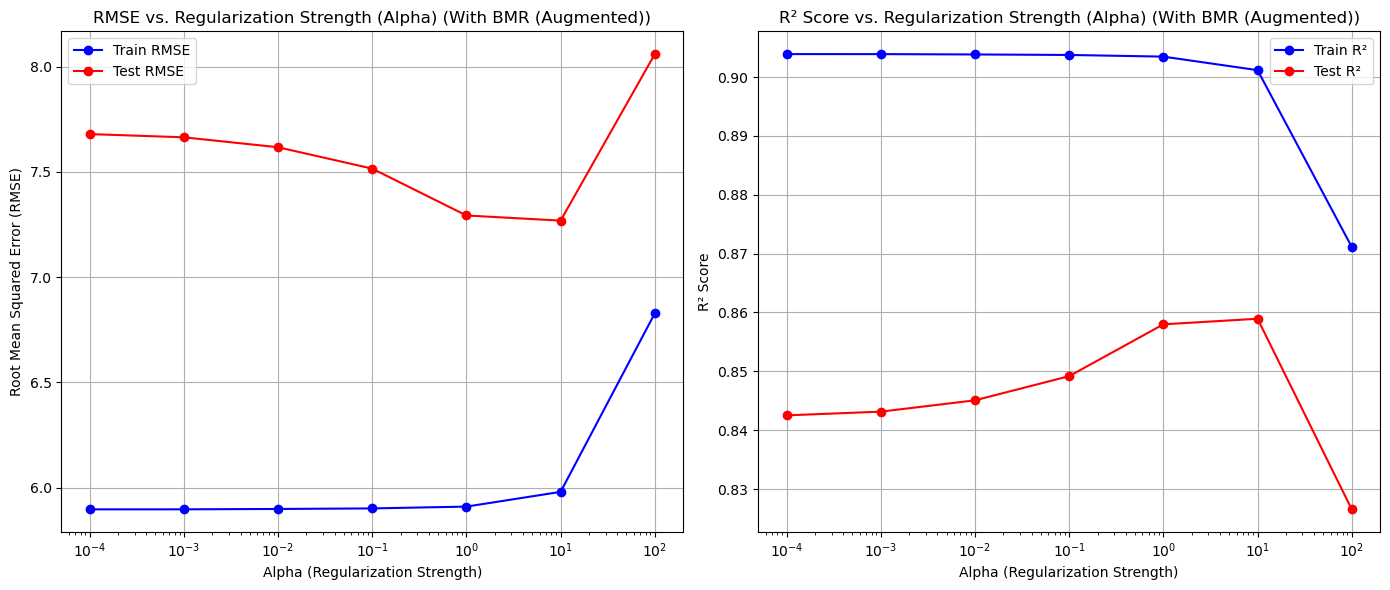

Best Alpha (With BMR (Augmented)): 10
Best Test RMSE (With BMR (Augmented)): 7.268155969014983
Best Test R² Score (With BMR (Augmented)): 0.8589352635428039

Ridge Analysis for Dataset without BMR (Augmented)


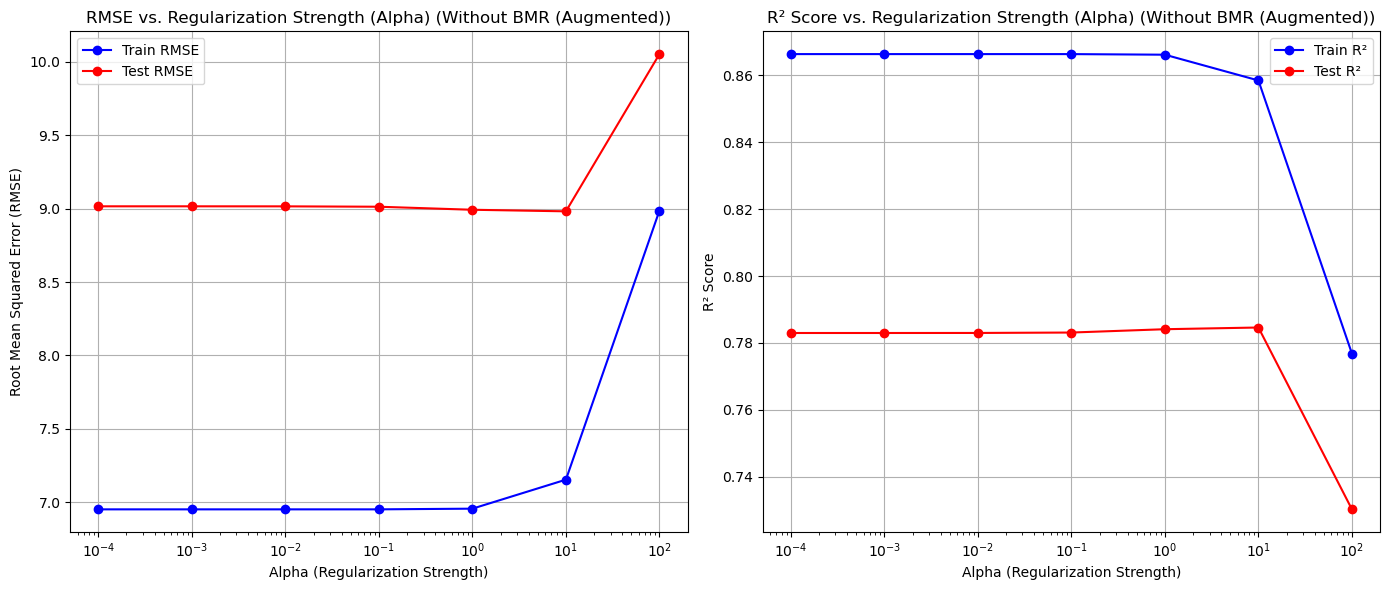

Best Alpha (Without BMR (Augmented)): 10
Best Test RMSE (Without BMR (Augmented)): 8.980878628760317
Best Test R² Score (Without BMR (Augmented)): 0.7846188757809803



In [47]:
def ridge_analysis(X_augmented, y_augmented, alpha_values, label):
    rmse_train = []
    rmse_test = []
    r2_train = []
    r2_test = []

    X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_aug = scaler.fit_transform(X_train_aug)
    X_test_aug = scaler.transform(X_test_aug)

    # Iterate over different alpha values
    for alpha in alpha_values:
        # Initialize and fit Ridge model
        ridge = Ridge(alpha=alpha, max_iter=10000)
        ridge.fit(X_train_aug, y_train_aug)
        
        # Predictions and evaluation on training set
        y_train_pred = ridge.predict(X_train_aug)
        rmse_train.append(np.sqrt(mean_squared_error(y_train_aug, y_train_pred)))
        r2_train.append(r2_score(y_train_aug, y_train_pred))
        
        # Predictions and evaluation on test set
        y_test_pred = ridge.predict(X_test_aug)
        rmse_test.append(np.sqrt(mean_squared_error(y_test_aug, y_test_pred)))
        r2_test.append(r2_score(y_test_aug, y_test_pred))

    # Plot RMSE and R² Score vs Alpha
    plt.figure(figsize=(14, 6))

    # RMSE plot
    plt.subplot(1, 2, 1)
    plt.plot(alpha_values, rmse_train, marker='o', label="Train RMSE", color='blue')
    plt.plot(alpha_values, rmse_test, marker='o', label="Test RMSE", color='red')
    plt.xscale('log')
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.title(f"RMSE vs. Regularization Strength (Alpha) ({label})")
    plt.legend()
    plt.grid(True)

    # R² Score plot
    plt.subplot(1, 2, 2)
    plt.plot(alpha_values, r2_train, marker='o', label="Train R²", color='blue')
    plt.plot(alpha_values, r2_test, marker='o', label="Test R²", color='red')
    plt.xscale('log')
    plt.xlabel("Alpha (Regularization Strength)")
    plt.ylabel("R² Score")
    plt.title(f"R² Score vs. Regularization Strength (Alpha) ({label})")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Find the best alpha based on test RMSE
    best_alpha_index = np.argmin(rmse_test)
    best_alpha = alpha_values[best_alpha_index]
    best_rmse_test = rmse_test[best_alpha_index]
    best_r2_test = r2_test[best_alpha_index]

    print(f"Best Alpha ({label}): {best_alpha}")
    print(f"Best Test RMSE ({label}): {best_rmse_test}")
    print(f"Best Test R² Score ({label}): {best_r2_test}\n")


alpha_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

# Perform Ridge analysis on the dataset with BMR
print("Ridge Analysis for Dataset with BMR (Augmented)")
ridge_analysis(X_with_bmr_aug, y, alpha_values, label="With BMR (Augmented)")

# Perform Ridge analysis on the dataset without BMR
print("Ridge Analysis for Dataset without BMR (Augmented)")
ridge_analysis(X_without_bmr_aug, y, alpha_values, label="Without BMR (Augmented)")

Both models perform best at alpha = 10, balancing bias and variance effectively. Higher values introduce excessive bias, leading to underfitting.

## 4. Now, let’s stratify the problem according to gender. Using the dataset_reduced, build two different supervised systems (one considering only the male subjects and one considering only the female subjects) based on Linear Regression which are capable of predicting the Final Weight (lbs) under the two conditions specified in the preamble. Optimize, per each system, the number of iterations of the learning procedure and the learning rate 𝜂. Plot the related learning curves and compare them.

using batch gradient descent

Number of samples for gender '0': 269
Number of samples for gender '0': 269
Male with BMR - Test MSE: 27989.403737691795
Male without BMR - Test MSE: 28116.66924228833


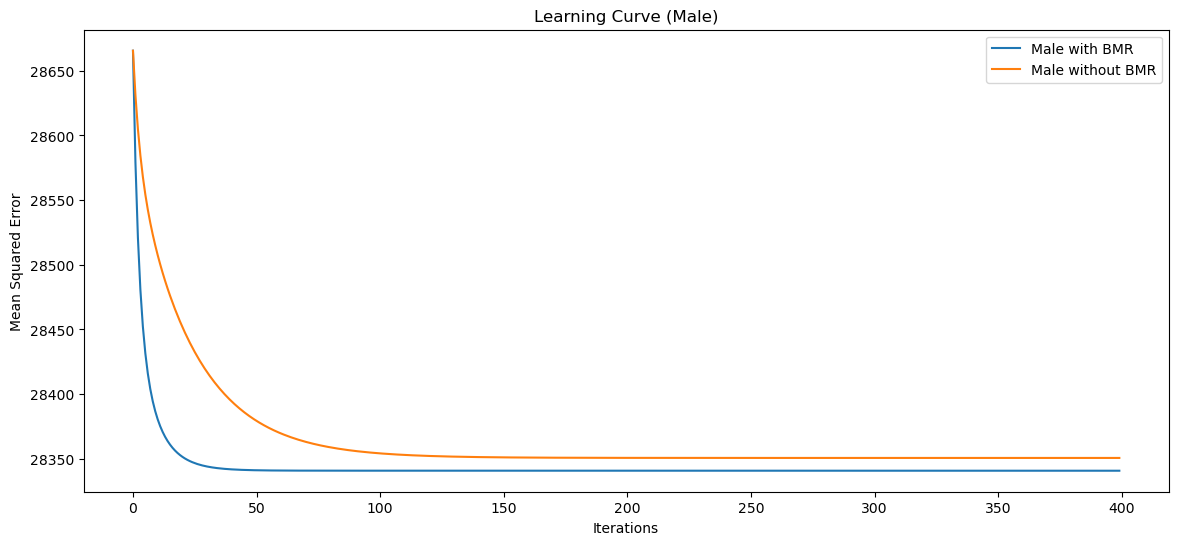

Number of samples for gender '1': 255
Number of samples for gender '1': 255
Female with BMR - Test MSE: 29206.022604580034
Female without BMR - Test MSE: 29168.824743773515


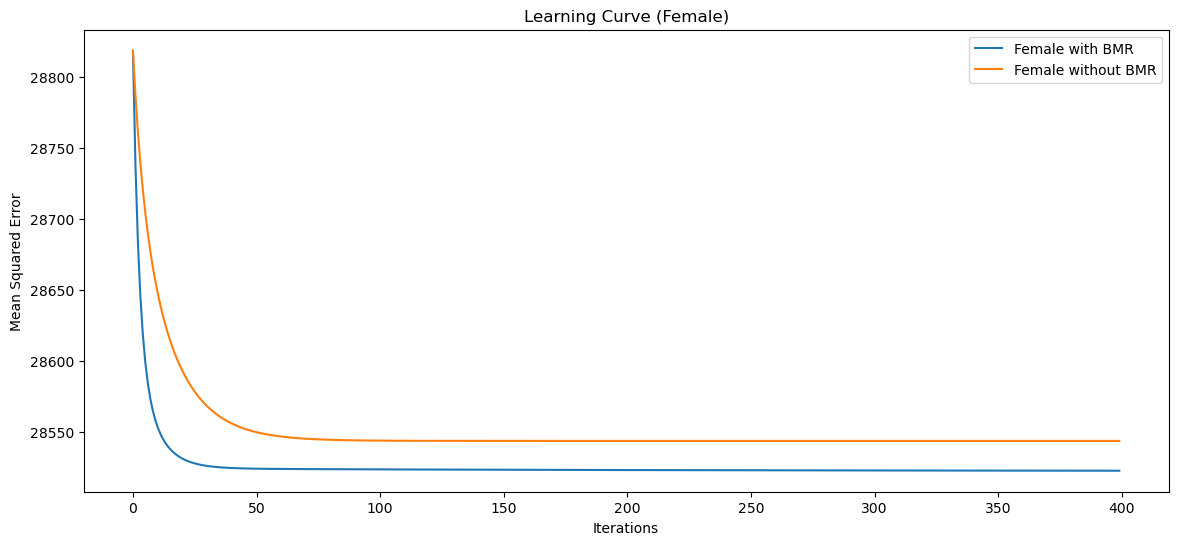

In [48]:
# Function to prepare data for each gender and each condition
def prepare_gender_data(df, gender, include_bmr):
    gender_data = df[df['Gender'] == gender].copy()  # Filter by gender
    
    # Debugging statement to check the number of samples after filtering
    print(f"Number of samples for gender '{gender}':", len(gender_data))
    
    if len(gender_data) == 0:
        raise ValueError(f"No data available for gender '{gender}'. Please check the dataset and filtering conditions.")
    
    if include_bmr:
        X = gender_data.drop(columns=["Final Weight (lbs)", "Gender"]).values  # Keep BMR
    else:
        X = gender_data.drop(columns=["Final Weight (lbs)", "Gender", "BMR (Calories)"]).values  # Exclude BMR
    y = gender_data["Final Weight (lbs)"].values  
    return X, y

def train_and_plot(X, y, learning_rate, iterations, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model and record costs
    theta, costs = batch_gradient_descent(X_train, y_train, learning_rate, iterations)

    # Plot learning curve
    plt.plot(costs, label=label)
    plt.xlabel("Iterations")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Learning Curve ({label.split(' ')[0]})")

    # Evaluate on test data
    y_test_pred = X_test.dot(theta)
    test_mse = mean_squared_error(y_test, y_test_pred)
    print(f"{label} - Test MSE: {test_mse}")

# Define parameters
learning_rate_male = 0.1
learning_rate_female = 0.1
iterations_male = 400
iterations_female = 400

# Train and plot for male subjects
X_male_bmr, y_male = prepare_gender_data(df, 0, include_bmr=True)
X_male_no_bmr, y_male_no_bmr = prepare_gender_data(df, 0, include_bmr=False)

plt.figure(figsize=(14, 6))
train_and_plot(X_male_bmr, y_male, learning_rate_male, iterations_male, "Male with BMR")
train_and_plot(X_male_no_bmr, y_male_no_bmr, learning_rate_male, iterations_male, "Male without BMR")
plt.legend()
plt.show()

# Train and plot for female subjects
X_female_bmr, y_female = prepare_gender_data(df, 1, include_bmr=True)
X_female_no_bmr, y_female_no_bmr = prepare_gender_data(df, 1, include_bmr=False)

plt.figure(figsize=(14, 6))
train_and_plot(X_female_bmr, y_female, learning_rate_female, iterations_female, "Female with BMR")
train_and_plot(X_female_no_bmr, y_female_no_bmr, learning_rate_female, iterations_female, "Female without BMR")
plt.legend()
plt.show()

This analysis suggests that different features may hold varying predictive importance across genders. In this case, BMR appears more predictive for males, while for females, it does not significantly alter the model’s performance. This could reflect underlying differences in how BMR correlates with the target variable for each gender in the dataset.

## 5) On this task you are going to reasonon the approaches based on the dataset_reduced. Do the gender-stratified approach (task 4) lead to better performances with respect to the global approach (task 3)?" For this task, measure how well each different approach developed above on dataset_reduced is capable of predicting the Final Weight (lbs) (under the conditions specified in the preamble) over the two genders present in the dataset. The performances to compare are the ones calculated only on test samples related to each specific gender. Visualize the obtained results.

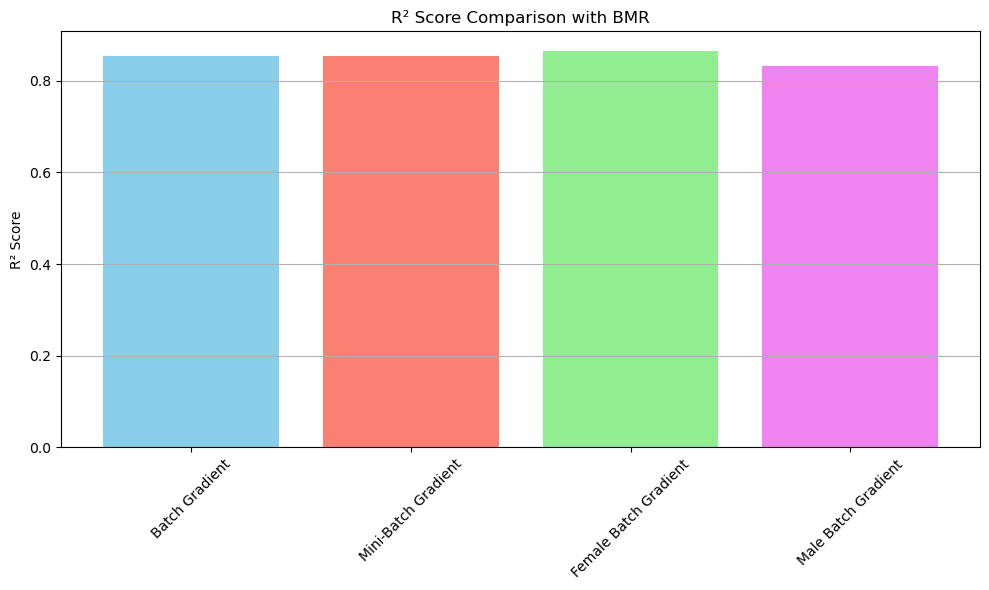

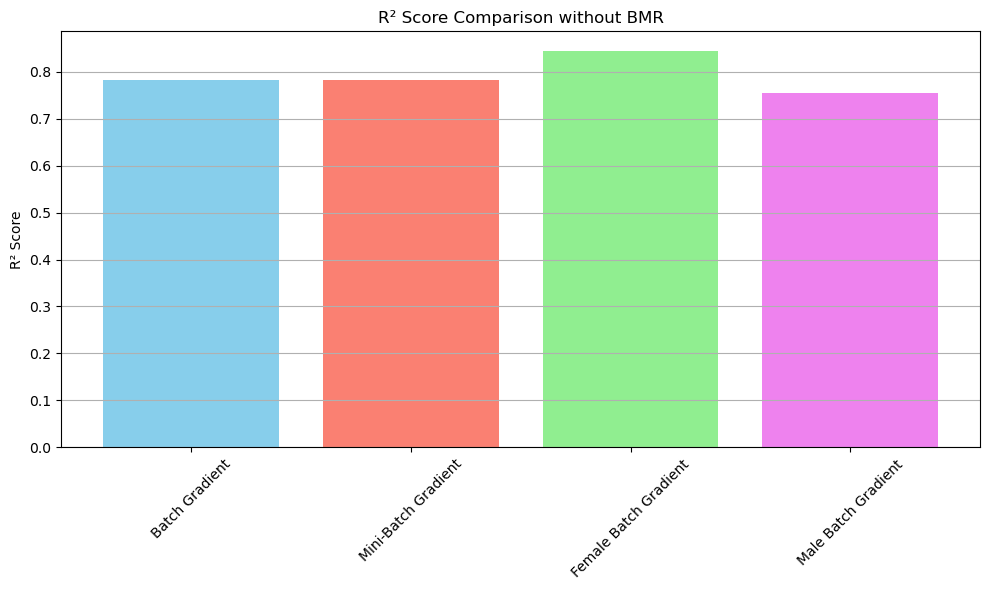

In [49]:
# Helper function to evaluate a model and return R² score
def evaluate_model(X_train, X_test, y_train, y_test, model):
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_test_pred)
    return test_r2

# Prepare dataset for gender-specific or global model
def prepare_data(df, include_bmr, gender_filter=None):
    if gender_filter is not None:
        df = df[df['Gender'] == gender_filter]
    
    if include_bmr:
        X = df.drop(columns=["Final Weight (lbs)", "Gender"]).values  
    else:
        X = df.drop(columns=["Final Weight (lbs)", "Gender", "BMR (Calories)"]).values  
    y = df["Final Weight (lbs)"].values  
    return X, y

# Evaluate models for each gender and condition
def evaluate_gender_model(df, gender_label, include_bmr):
    gender_filter = 1 if gender_label == "Female" else 0
    X, y = prepare_data(df, include_bmr=include_bmr, gender_filter=gender_filter)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    batch_model = LinearRegression()  
    r2_batch = evaluate_model(X_train, X_test, y_train, y_test, batch_model)
    
    return r2_batch

# Evaluate global models (Batch and Mini-Batch) for each condition
def evaluate_global_models(df, include_bmr):
    X, y = prepare_data(df, include_bmr=include_bmr)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    batch_model = LinearRegression()  
    r2_batch_global = evaluate_model(X_train, X_test, y_train, y_test, batch_model)
    
    mini_batch_model = LinearRegression()  
    r2_mini_batch_global = evaluate_model(X_train, X_test, y_train, y_test, mini_batch_model)
    
    return r2_batch_global, r2_mini_batch_global

# Plotting results
def plot_results(r2_scores, title):
    labels = list(r2_scores.keys())
    scores = list(r2_scores.values())
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(labels, scores, color=['skyblue', 'salmon', 'lightgreen', 'violet'])
    ax.set_ylabel("R² Score")
    ax.set_title(title)
    ax.grid(axis='y')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Perform analysis for both conditions
# Condition 1: with BMR
r2_scores_with_bmr = {
    "Batch Gradient": evaluate_global_models(df, include_bmr=True)[0],
    "Mini-Batch Gradient": evaluate_global_models(df, include_bmr=True)[1],
    "Female Batch Gradient": evaluate_gender_model(df, "Female", include_bmr=True),
    "Male Batch Gradient": evaluate_gender_model(df, "Male", include_bmr=True)
}
plot_results(r2_scores_with_bmr, "R² Score Comparison with BMR")

# Condition 2: without BMR
r2_scores_without_bmr = {
    "Batch Gradient": evaluate_global_models(df, include_bmr=False)[0],
    "Mini-Batch Gradient": evaluate_global_models(df, include_bmr=False)[1],
    "Female Batch Gradient": evaluate_gender_model(df, "Female", include_bmr=False),
    "Male Batch Gradient": evaluate_gender_model(df, "Male", include_bmr=False)
}
plot_results(r2_scores_without_bmr, "R² Score Comparison without BMR")


All four models achieve similar R² scores, with values around 0.8

The models specifically trained for males and females show comparable performance to the global models. This suggests that the addition of BMR might reduce the need for separate models by capturing key predictive information applicable to both gender

Without BMR, the R² scores are generally lower than in the first plot, indicating that BMR is an important variable for predicting the Final Weight.

## 6. Provide a final discussion on the results obtained above.

The series of analyses highlights the importance of including BMR, using optimal regularization, and potentially employing gender-specific models for best performance. BMR significantly enhances the model’s ability to predict the target variable, especially when used with Ridge or Lasso regression at optimal regularization strengths. Gender-specific analysis reveals that feature relevance can vary between groups, suggesting the need for demographic stratification in predictive modeling. This approach allows for capturing subtle differences in how features relate to the target variable, ultimately leading to more accurate and generalizable models.